In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver
from src import regmod_torch

from tqdm import tqdm
import importlib

## Evaluation of optimal alpha and delta

Contents:
- Grid search like
    - Alpha
    - Delta
- Joint optimization
    - Alpha
    - Both at same time

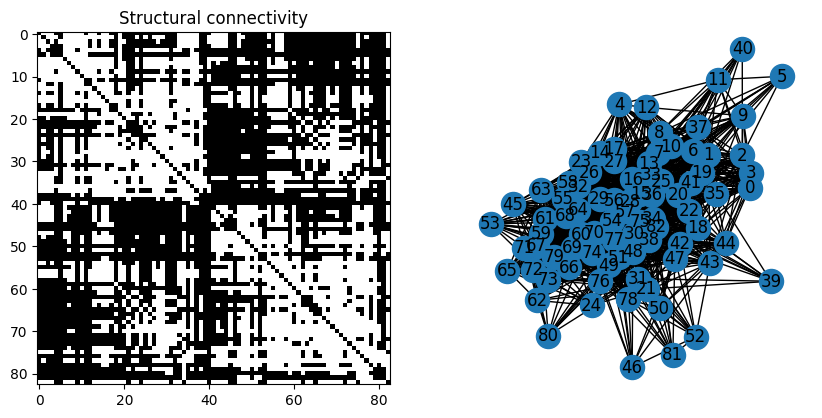

In [5]:
path_to_data = "../resources"

# Could be 50, 100, 200, 400
delay_max = 400

path_to_ftract = f"/Users/mikichan/Desktop/mywork/atlas_data/f-tract_v2112/F-TRACT-090624/{delay_max}"

filename = "bundle_probability_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))

adj = adj[:83, :83]
adj -= np.diag(np.diag(adj))

bundle_prob_thresh = 0.9

adj = (adj > bundle_prob_thresh).copy().astype(int)

bundle_prob = utils.load(op.join(path_to_data, "bundle_probability_atlas.pkl"))
bundle_prob = bundle_prob[:83, :83]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = utils.load(op.join(path_to_data, "adj_probability_ftract.pkl"))
ftract_prob = ftract_prob[:83, :83]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

In [7]:
with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

prob_thresh = 0
y_ground_mat *= ftract_prob > prob_thresh
y_ground = utils.remove_diagonal_entries(y_ground_mat).flatten()

In [8]:
import os
if os.path.exists(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl'):
    design_matrices_subopts = utils.load(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl')
else:
    design_matrices_subopts = []
    for k in tqdm(range(2)):
        design_matrices_subopts.append(regmod.get_shortest_matrices(adjacency=adj, n_subopt=k))

    utils.save(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl', design_matrices_subopts)

### Grid search like - Varying $\alpha$

In [6]:
max_path_depth = 1
alpha_space = np.linspace(0, 2, 21)

alphas_results = {}
for alpha in tqdm(alpha_space):
    design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
    design_model = solver.torch.tensor(design_shortest)

    # Define mapping area
    non_zero_mask = y_ground > 0
    y_masked = y_ground[non_zero_mask]
    design_model_masked = design_model[non_zero_mask]

    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=0,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)
    
    alphas_results[alpha] = (x_opt,loss)

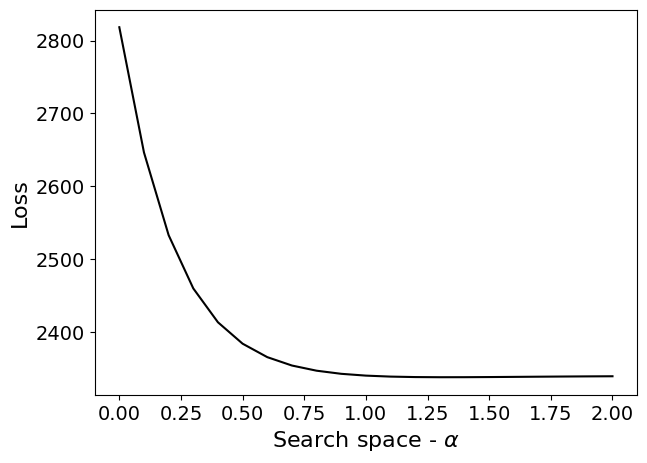

In [97]:
fig, ax = plt.subplots(1, figsize=(7, 5))
losses = [alphas_results[alpha][1] for alpha in alpha_space]
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel(r'Search space - $\alpha$', fontsize=16)
ax.tick_params(labelsize=14)
ax.plot(alpha_space, losses, color='k')
# ax.scatter([alpha_space[1], alpha_space[17]], [losses[1], losses[17]], 100, c='r', marker='x', label='local minima')
# ax.legend(prop={'size': 16})

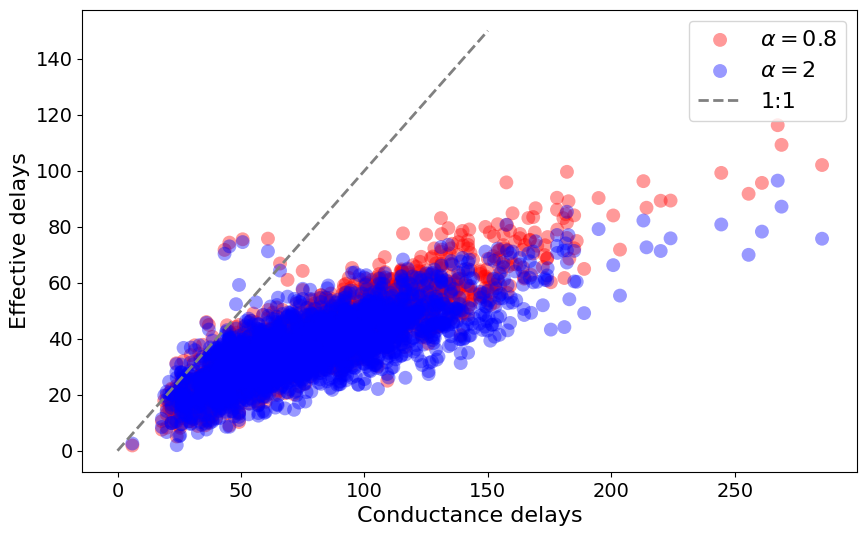

In [107]:
x1 = alphas_results[0.8][0]
x2 = alphas_results[2][0]
y = y_ground

x1_mask = x1 > 1
x2_mask = x2 > 1
y_mask = y != 0
xy_mask1 = np.logical_and(x1_mask, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x2_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(y[xy_mask1], x1[xy_mask1], s=100, alpha=.4, edgecolors="none", color='red', label=r'$\alpha=0.8$')
ax.scatter(y[xy_mask2], x2[xy_mask2], s=100, alpha=.4, edgecolors="none", color='blue', label=r'$\alpha=2$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=16)

### Grid search like - Varying $\delta$

In [5]:
max_path_depth = 1

delta_space = np.linspace(0, 60, 21)
alpha = 0.8

design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
design_model = solver.torch.tensor(design_shortest)

delta_results = {}
for delta in tqdm(delta_space):

    # Define mapping area
    non_zero_mask = y_ground > 0
    y_masked = y_ground[non_zero_mask]
    design_model_masked = design_model[non_zero_mask]

    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=delta,
                                            l2_penalty=1, verbose=False)
    
    delta_results[delta] = (x_opt,loss)

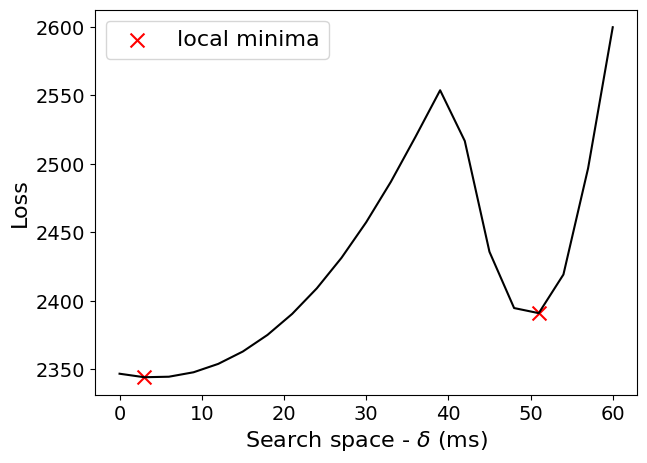

In [77]:
fig, ax = plt.subplots(1, figsize=(7, 5))
losses = [delta_results[delta][1] for delta in delta_space]
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel(r'Search space - $\delta$ (ms)', fontsize=16)
ax.tick_params(labelsize=14)
ax.plot(delta_space, losses, color='k')
ax.scatter([delta_space[1], delta_space[17]], [losses[1], losses[17]], 100, c='r', marker='x', label='local minima')
ax.legend(prop={'size': 16})

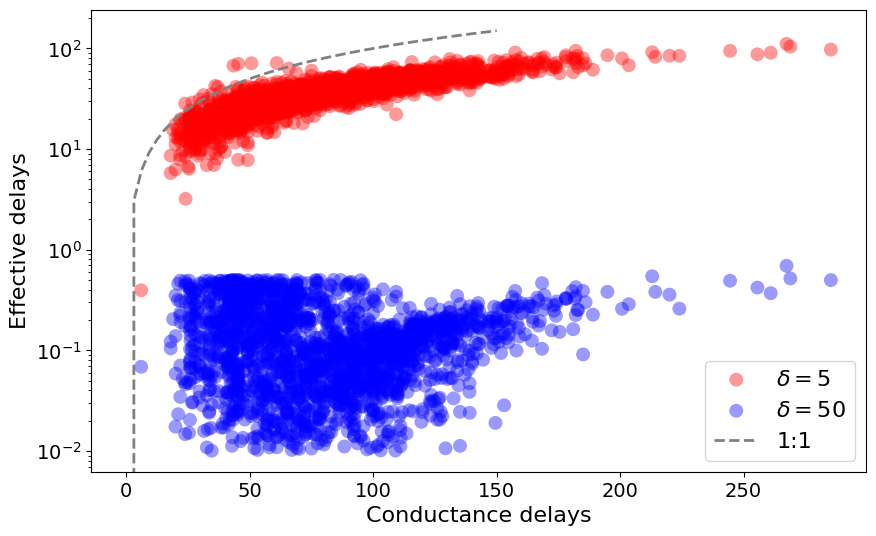

In [92]:
# plot the mapping curve and see what it looks like
x1 = delta_results[delta_space[1]][0]
x2 = delta_results[delta_space[17]][0]
y = y_ground

x_mask1 = x1 > 1e-2
x_mask2 = x2 > 1e-2
y_mask = y != 0
xy_mask1 = np.logical_and(x_mask1, y_mask).numpy().astype(bool)
xy_mask2 = np.logical_and(x_mask2, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(y[xy_mask1], x1[xy_mask1], s=100, alpha=.4, edgecolors="none", color='red', label=r'$\delta=5$')
ax.scatter(y[xy_mask2], x2[xy_mask2], s=100, alpha=.4, edgecolors="none", color='blue', label=r'$\delta=50$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,150), np.linspace(0,150), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.set_yscale('log')
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
ax.legend(fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [45]:
utils.save('../resources/alpha_varying.pkl', (alpha_space, alphas_results))
utils.save('../resources/delta_varying.pkl', (delta_space, delta_results))

### Variying - $\alpha$ & $\delta$

In [231]:
max_path_depth = 1

# # Wide 
# alpha_space = np.linspace(0, 10, 21)
# delta_space = np.linspace(0, 60, 21)

# Coarse
alpha_space = np.linspace(0, 2, 11)
delta_space = np.linspace(25, 40, 11)

ad_results = {}
for aidx, alpha in enumerate(tqdm(alpha_space)):
    for didx, delta in enumerate(delta_space):
        
        design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)

        # Define mapping area
        non_zero_mask = y_ground > 0
        y_masked = y_ground[non_zero_mask]
        design_model_masked = design_shortest[non_zero_mask]

        non_zero_mask = solver.torch.from_numpy(non_zero_mask)
        y_masked = solver.torch.from_numpy(y_masked)
        design_model_masked = solver.torch.from_numpy(design_model_masked)

        np.random.seed(99)
        x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

        x_opt, loss = solver.gradient_descent_solver(x_init, y_masked, design_model_masked,
                                                n_iter=5000, verbose=False, 
                                                early_stop=1e-10, step_size=5e-1, delta=delta,
                                                l2_penalty=1)
        
        ad_results[(aidx, didx)] = (x_opt,loss)

100%|██████████| 11/11 [18:01:35<00:00, 5899.55s/it]   


In [9]:
# utils.save('../resources/landscape_results_coarser.pkl', ad_results)
ad_results = utils.load('../resources/landscapes_results_coarser.pkl')

# alpha_space = np.linspace(0, 2, 11)
# delta_space = np.linspace(25, 40, 11)

# fibers_array = utils.load(op.join(path_to_data,'fiber_lengths.pkl'))
# opt = utils.add_diagonal_entries(ad_results[(5,3)][0].reshape(fibers_array.shape[0], fibers_array.shape[1]-1))
# plt.imshow(opt)
# utils.save('./effdelay_scale1_peak400.pkl', opt)

In [236]:
# Loss / Speed / fiber length correlation Landscape
from sklearn.linear_model import LinearRegression
from scipy import stats

fibers_array = utils.load('../resources/fiber_lengths.pkl')

speed_land = np.zeros((len(alpha_space), len(delta_space)))
corr_land = np.zeros((len(alpha_space), len(delta_space)))
loss_land = np.zeros((len(alpha_space), len(delta_space)))

for aidx, alpha in enumerate(alpha_space):
    for didx, delta in enumerate(delta_space):
        opt, loss = ad_results[(aidx,didx)]
        loss_land[aidx, didx] = loss
        opt = utils.add_diagonal_entries(opt.reshape(fibers_array.shape[0], fibers_array.shape[1]-1))

        mask = np.logical_and((opt > 0.1), (fibers_array > 0))

        y = opt[mask]
        x = fibers_array[mask]

        model = LinearRegression()
        model.fit(x.reshape(-1,1), y)

        r_squared = model.score(x.reshape(-1,1), y)

        model_est_speed = LinearRegression()
        model_est_speed.fit(y.reshape(-1,1)/1e3, x/1e3)
        
        speed_land[aidx, didx] = model_est_speed.coef_[0]
        
        corr = stats.pearsonr(x, y)[0]
        corr_land[aidx, didx] = corr

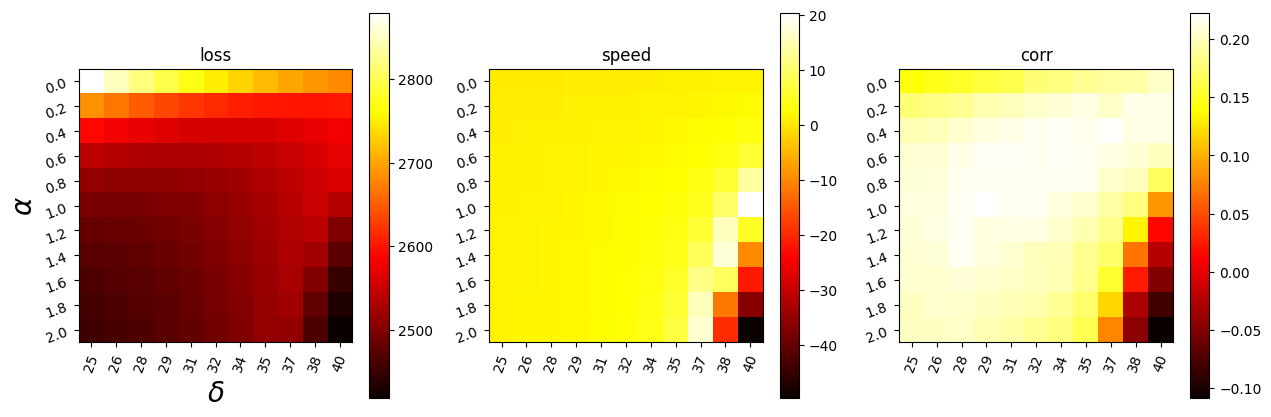

In [297]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

lands = [loss_land, speed_land, corr_land]
lands_label = ['loss', 'speed', 'corr']
for k in range(3):
    im = ax[k].imshow(lands[k], cmap='hot')
    ax[k].set_xticks(np.arange(len(alpha_space)))
    ax[k].set_xticklabels(delta_space.astype(int), rotation=70)
    ax[k].set_title(lands_label[k])
    plt.colorbar(im, ax=ax[k])
    ax[k].set_yticks(np.arange(len(alpha_space)))
    ax[k].set_yticklabels(np.round(alpha_space.astype(float),3), rotation=20)
    
    if k == 0:
        
        ax[k].set_xlabel(r'$\delta$', size=20)
        ax[k].set_ylabel(r'$\alpha$', size=20)

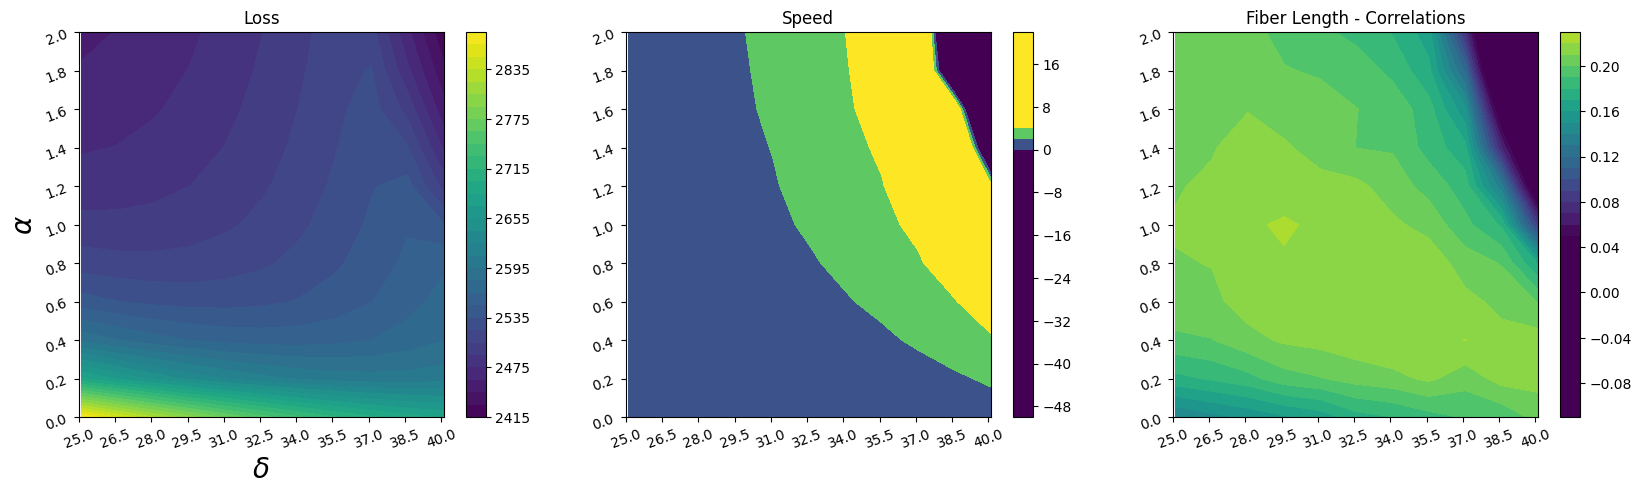

In [295]:
x, y = np.meshgrid(delta_space, alpha_space)

fig, ax = plt.subplots(1,3, figsize=(20,5))

lands = [loss_land, speed_land, corr_land]
lands_label = ['Loss', 'Speed', 'Fiber Length - Correlations']

crosses_pairs = [(11,2), (10,2), (9,2), (12,1), (11,1), (10,1)]
for k in range(3):
    if k == 1:
        cs = ax[k].contourf(x/3, y * 2, lands[k], 40, vmin=0, vmax=4)
    elif k == 2:
        cs = ax[k].contourf(x/3, y * 2, lands[k], 40, vmin=0.05, vmax=0.25)
    else:
        cs = ax[k].contourf(x/3, y * 2, lands[k], 40)
    ax[k].set_xticks(np.arange(len(delta_space))/2+8.3, labels=delta_space, rotation=20) # Realign the ticks
    ax[k].set_title(lands_label[k])
    plt.colorbar(cs, ax=ax[k])

    ax[k].set_yticks(np.arange(len(alpha_space))[::-1]/2.5, 
                     labels=np.round(alpha_space.astype(float)[::-1],3), rotation=20)
    if k == 0:
        ax[k].set_xlabel(r'$\delta$', size=20)
        ax[k].set_ylabel(r'$\alpha$', size=20)
    
    # for pair in crosses_pairs:
    #     ax[k].scatter([pair[0]],[pair[1]], marker='x', color='r')

In [286]:
best_corrs = np.array([lands[2][pair[1], pair[0]] for pair in crosses_pairs])
best_speeds = np.array([lands[1][pair[1], pair[0]] for pair in crosses_pairs])
best_losses = np.array([lands[0][pair[1], pair[0]] for pair in crosses_pairs])

ratios_corrs = best_corrs/corr_land.max()
ratios_losses = best_losses/loss_land.min()
ratios_losses

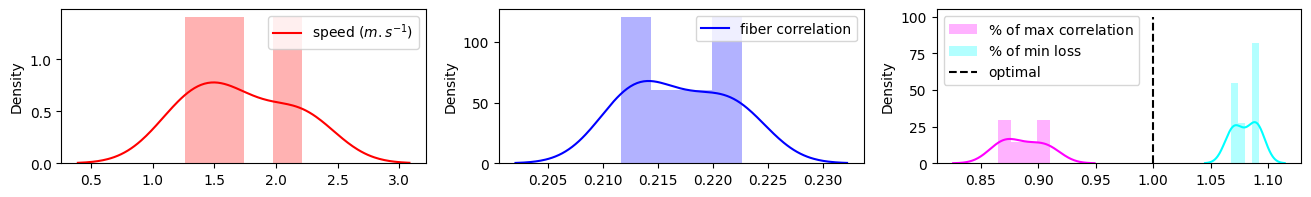

In [194]:
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(16,2))

sns.kdeplot(best_speeds, ax=ax[0], color='red', label=r'speed $(m.s^{-1})$')
ax[0].hist(best_speeds, density=True, alpha=0.3, bins=4, color='red')
sns.kdeplot(best_corrs, ax=ax[1], color='blue', label='fiber correlation')
ax[1].hist(best_corrs, density=True, alpha=0.3, bins=4, color='blue')
sns.kdeplot(ratios_corrs, ax=ax[2], color='magenta')
ax[2].hist(ratios_corrs, density=True, alpha=0.3, bins=4, color='magenta', label=r'$\%$ of max correlation')
sns.kdeplot(ratios_losses, ax=ax[2], color='cyan')
ax[2].hist(ratios_losses, density=True, alpha=0.3, bins=4, color='cyan', label=r'$\%$ of min loss')
ax[2].vlines(x=1, ymin=0, ymax=100, linestyle='--', color='k', label='optimal')
ax[0].legend()
ax[1].legend()
ax[2].legend()

### Joint Optimization - Alpha

In [6]:
max_path_depth = 1

np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).type(solver.torch.float).requires_grad_(True)
alpha_init = solver.torch.tensor(np.random.rand(1)).type(solver.torch.float).requires_grad_(True)

ldesign_model = solver.torch.tensor(design_matrices_subopts[max_path_depth]).type(solver.torch.float)
# design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
# design_model = solver.torch.tensor(design_shortest)

# Define mapping area
non_zero_mask = y_ground > 0
y_masked = y_ground[non_zero_mask]

x = utils.deepcopy(x_init)
x_opt, a_opt, loss = solver.gradient_descent_solver_alpha(x, y_masked, ldesign_model, non_zero_mask, alpha_init, 
                                        n_iter=10000, verbose=False, 
                                        early_stop=1e-10, step_size=5e-1, delta=0,
                                        #early_stop=1e-10, step_size=5e-1,
                                        l2_penalty=1)

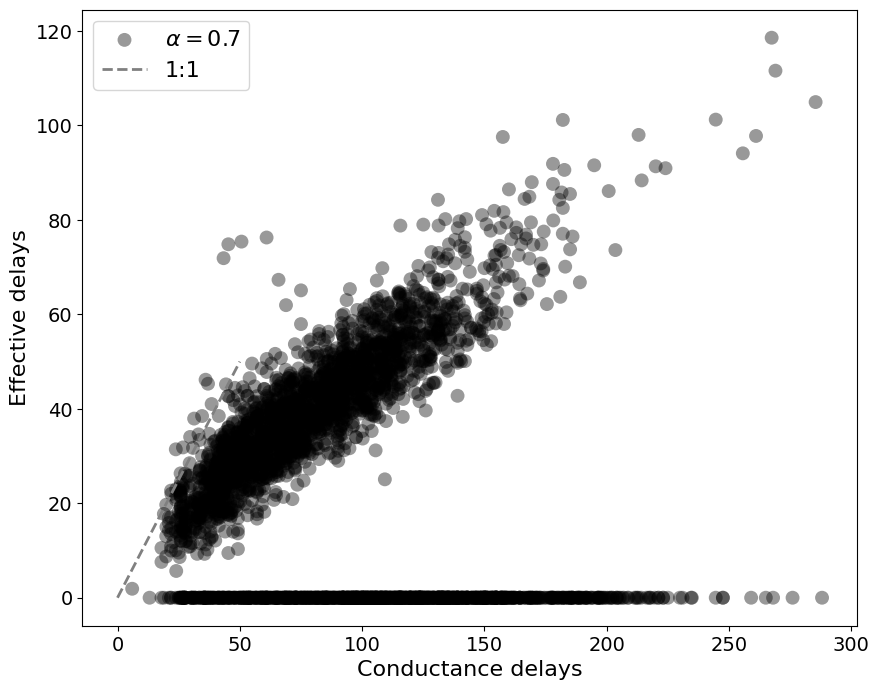

In [68]:
x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none", color='k', label=rf'$\alpha={np.round(a_opt,2)}$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,50), np.linspace(0,50), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
ax.legend(fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [ ]:
# utils.save('../resources/joint_optim_alpha.pkl', (x_opt,a_opt))

### Joint Optimization - Delta

In [64]:
max_path_depth = 1

alpha = 0.8
design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
design_model = solver.torch.tensor(design_shortest)

# Define mapping area
non_zero_mask = y_ground > 0
y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)
delta_init = (50 * solver.torch.tensor(np.random.rand(1))).requires_grad_(True)

x = utils.deepcopy(x_init)
delta = utils.deepcopy(delta_init)
x_opt, d_opt, loss = solver.gradient_descent_solver_delta(x, y_masked, design_model_masked, delta,
                                        n_iter=10000, verbose=False, 
                                        early_stop=1e-10, step_size=5e-1,
                                        l2_penalty=1)

In [ ]:
x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none", color='k', label=rf'$\delta={int(np.round(d_opt,0))}$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,50), np.linspace(0,50), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
ax.legend(fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [ ]:
# utils.save('../resources/joint_optim_delta.pkl', (x_opt,d_opt))

### Joint Optimization - Alpha + Delta

In [7]:
max_path_depth = 1

np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).type(solver.torch.float).requires_grad_(True)
alpha_init = solver.torch.tensor(np.random.rand(1)).type(solver.torch.float).requires_grad_(True)
delta_init = (50 * solver.torch.tensor(np.random.rand(1))).type(solver.torch.float).requires_grad_(True)

ldesign_model = solver.torch.tensor(design_matrices_subopts[max_path_depth]).type(solver.torch.float)

# Define mapping area
non_zero_mask = y_ground > 0
y_masked = y_ground[non_zero_mask]

x = utils.deepcopy(x_init)
delta = utils.deepcopy(delta_init)

x_opt, hyp_opt, loss = solver.effect_delay_solver(x, y_masked, ldesign_model, non_zero_mask, alpha_init, delta=delta_init,
                                        n_iter=10000, verbose=False, 
                                        early_stop=1e-10, step_size=5e-1,
                                        #early_stop=1e-10, step_size=5e-1,
                                        l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

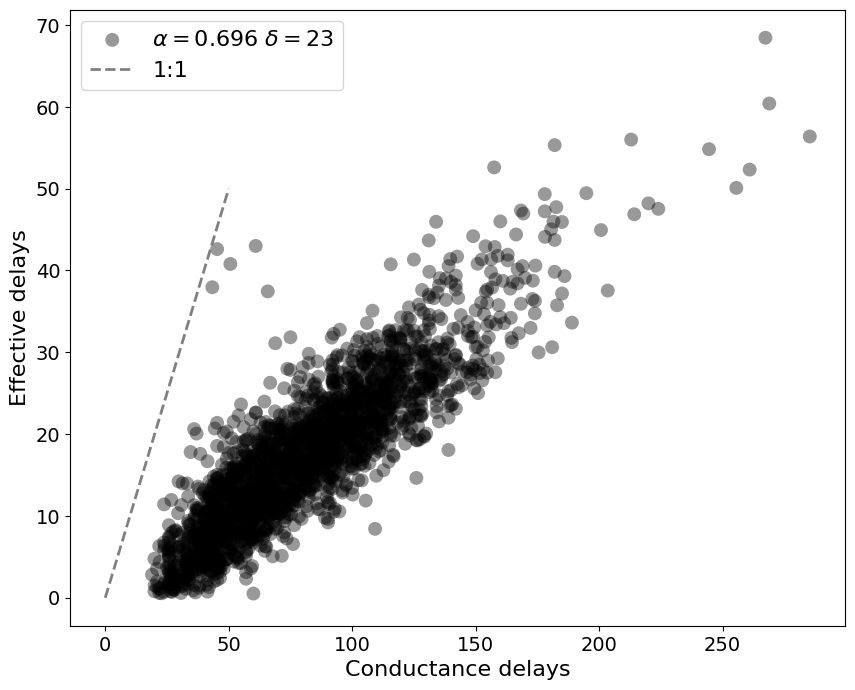

In [14]:
x = x_opt
y = y_ground

x_mask = x > 0.5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none", 
           color='k', label=rf'$\alpha={np.round(hyp_opt[0],3)}$ $\delta={int(np.round(hyp_opt[1],0))}$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,50), np.linspace(0,50), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
ax.legend(fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [12]:
# utils.save('../resources/joint_optim_alpha-delta.pkl', (x_opt,hyp_opt))